In [69]:
%config IPCompleter.greedy=True
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [56]:
from dateutil.parser import parse as parse_date
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spotipy
import spotipy.util as util
import pyplot_themes as themes

In [85]:
user_id = '6sv95ub14tdhriy0zglf28t6a'
client_id='8e9d4b3d23914cd095065e4f47591e0a'
client_secret='1673f4fe2ae8422a8f3548d1a1f6ad0c'

In [86]:
token = util.prompt_for_user_token(user_id,
                                   'playlist-read-collaborative',
                                   client_id=client_id,
                                   client_secret=client_secret,
                                  redirect_uri='http://mysite.com/callback/fav')

In [87]:
sp = spotipy.Spotify(auth=token)

In [49]:
user_playlists = sp.user_playlists(user=user_id)

for playlist in user_playlists['items']:
    print(playlist['id'], playlist['name'])

6BgM0WE6GXv2HLXYj1D4lu Quarantine Lib
0vvXsWCC9xrXsKd4FyS8kM lofi hip hop music - beats to relax/study to
42PZihHa5JlJOqfNjd470c Driving
3NVmRhOFS8OATMTRHP6mUB In Case Of Running
21BwKkjfxTc1AKYTl7QxkL wedding
5y7VC5N6v4M8ZqeN7SWTvK Detached
6sRetqhCIdjFqh1AONjCF2 From Movies


In [50]:
playlist = sp.user_playlist(user_id, '6BgM0WE6GXv2HLXYj1D4lu')
tracks = playlist['tracks']['items']
next_uri = playlist['tracks']['next']
for _ in range(int(playlist['tracks']['total'] / playlist['tracks']['limit'])):
    response = sp._get(next_uri)
    tracks += response['items']
    next_uri = response['next']

## Simple

In [51]:
tracks_df = pd.DataFrame([(track['track']['id'],
                           track['track']['artists'][0]['name'],
                           track['track']['name'],
                           parse_date(track['track']['album']['release_date']) if track['track']['album']['release_date'] else None,
                           parse_date(track['added_at']))
                          for track in playlist['tracks']['items']],
                         columns=['id', 'artist', 'name', 'release_date', 'added_at'] )

In [52]:
tracks_df['added_at'] = pd.to_datetime(tracks_df['added_at']).dt.date

In [53]:
tracks_df.head(10)

,id,artist,name,release_date,added_at
0,43yoPh5r95O0sltSQoY6Iw,Cat Power,Stuck Inside of Mobile with the Memphis Blues ...,2007-10-25,2019-09-21
1,5a4MgIUSf9K8wXLSm6xPEx,Pink Floyd,High Hopes,1994-04-05,2019-09-21
2,7u8yddev0YnNFGkZoP8X2t,Blur,To the End - 2012 Remaster,1994-04-25,2019-09-21
3,5g19EQEmBkiFuyTztsFjMU,Stereophonics,Indian Summer,2013-03-04,2019-09-21
4,7jY2puQFxonAToK9HSnIuo,The London Suede,He's Gone,1999-05-03,2019-09-21
5,2DPiTxkAJppAZ32M3jm6CZ,Brett Anderson,Back to You,2016-12-02,2019-09-21
6,3BFKNc9YZltqCYn7eSST4h,Oasis,The Masterplan - Remastered,1995-10-02,2019-09-21
7,3ItmWMjqF2ECKPvbSfEfw0,Lake Of Tears,The Homecoming,1999-01-01,2019-09-21
8,3RptaQ5Xb8WvtpItZ2f9Hi,Slipknot,Snuff,2008-08-22,2019-09-21
9,5TTGoX70AFrTvuEtqHK37S,Arctic Monkeys,No. 1 Party Anthem,2013-09-09,2019-09-21


### Top artists

In [54]:
tracks_df \
    .groupby('artist') \
    .count()['id'] \
    .reset_index() \
    .sort_values('id', ascending=False) \
    .rename(columns={'id': 'amount'}) \
    .head(10)

,artist,amount
271,Sublime,20
67,Dire Straits,18
294,The Cure,13
15,BANKS,12
98,Gorillaz,11
40,Cage The Elephant,11
231,Radiohead,11
221,Pink Floyd,11
78,Eminem,11
206,Oasis,11


### Top artists by year

In [145]:
tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year) \
    .groupby(['artist', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False) \
    .pivot('artist', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
artist,,
2Pac,1.000000,0.000000
311,0.000000,3.000000
88rising,1.000000,4.000000
A Tribe Called Quest,0.000000,1.000000
AC/DC,0.000000,7.000000
Aerosmith,1.000000,2.000000
Against Me!,0.000000,2.000000
Alex Turner,1.000000,3.000000
Alice Cooper,0.000000,1.000000


In [146]:
counted_year_df = tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year) \
    .groupby(['artist', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_artist = counted_year_df \
    .groupby('year_added') \
    .head(5) \
    .artist \
    .unique()

counted_year_df \
    [counted_year_df.artist.isin(in_top_5_year_artist)] \
    .pivot('artist', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
artist,,
BANKS,7.000000,5.000000
Cage The Elephant,0.000000,11.000000
Dire Straits,7.000000,11.000000
Glass Animals,8.000000,2.000000
Gorillaz,7.000000,4.000000
Oasis,1.000000,10.000000
Pulp,6.000000,1.000000
Sublime,0.000000,20.000000
The Cure,1.000000,13.000000


### Release date per year

In [37]:
tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year,
            year_released=tracks_df.release_date.dt.year) \
    .groupby(['year_released', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False) \
    .pivot('year_released', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
year_released,,
1964,0.000000,1.000000
1965,1.000000,8.000000
1966,0.000000,3.000000
1967,1.000000,7.000000
1968,0.000000,1.000000
1969,0.000000,6.000000
1970,0.000000,4.000000
1971,2.000000,3.000000
1972,2.000000,0.000000


In [38]:
counted_release_year_df = tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year,
            year_released=tracks_df.release_date.dt.year) \
    .groupby(['year_released', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_released = counted_release_year_df \
    .groupby('year_added') \
    .head(5) \
    .year_released \
    .unique()

counted_release_year_df \
    [counted_release_year_df.year_released.isin(in_top_5_year_released)] \
    .pivot('year_released', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2019,2020
year_released,,
2008,10.000000,8.000000
2014,15.000000,12.000000
2016,11.000000,29.000000
2017,17.000000,43.000000
2018,13.000000,26.000000
2019,4.000000,38.000000
2020,0.000000,61.000000


## Audio features

In [10]:
def get_features_from_playlist(user='', playlist_id=''):
    '''
    Takes in a user_id and a playlist_id and returns a dataframe of a user's playlist songs
    '''
    df_result = pd.DataFrame()
    track_list = ''
    uploader_list = []
    added_ts_list = []
    artist_list = []
    title_list = []
    release_date =[]

    more_songs = True #As long as there is tracks not fetched from API, continue looping
    offset_index = 0
    
    if playlist_id != '' and user == '':
        print("Enter username for playlist")
        return

    while more_songs:
        songs = sp.user_playlist_tracks(user, playlist_id=playlist_id, offset=offset_index)

        for song in songs['items']:
            #join track ids to a single string as an input parameter for audio_features function
            track_list += song['track']['id'] +','

            #get the time when the song was added
            added_ts_list.append(song['added_at'])

            #get the title of the song
            title_list.append(song['track']['name'])
            
            #get all the artists in the song
            artists = song['track']['artists']
            artists_name = ''
            for artist in artists:
                artists_name += artist['name']  + ','
            artist_list.append(artists_name[:-1])
            
            #get user who added song in the playlist, catering for collaboration playlists
            uploader_list.append(song['added_by']['id'])
            
            # get release date of the album
            release_date.append(song['track']['album']['release_date'])

        #get the track features and append into a dataframe
        track_features = sp.audio_features(track_list[:-1])
        df_temp = pd.DataFrame(track_features)
        df_result = df_result.append(df_temp)
        track_list = ''

        if songs['next'] == None:
            # no more songs in playlist
            more_songs = False
        else:
            # get the next n songs
            offset_index += songs['limit']
            print('Progress: ' + str(offset_index) + ' of '+ str(songs['total']))

    #add the timestamp added, title and artists of a song
    df_result['added_at'], df_result['song_title'], df_result['artists'] = added_ts_list, title_list, artist_list
    
        
    print('--- COMPLETED ---')
    
    return df_result    

In [88]:
tracks_w_features = get_features_from_playlist(user='6sv95ub14tdhriy0zglf28t6a', 
                                       playlist_id='6BgM0WE6GXv2HLXYj1D4lu')

Progress: 100 of 815
Progress: 200 of 815
Progress: 300 of 815
Progress: 400 of 815
Progress: 500 of 815
Progress: 600 of 815
Progress: 700 of 815
Progress: 800 of 815
--- COMPLETED ---


In [12]:
tracks_w_features = tracks_w_features[['id', 'artists', 'song_title', 'added_at', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature']]

In [89]:
tracks_w_features['added_at'] = pd.to_datetime(tracks_w_features['added_at'])

In [90]:
df_2020 = tracks_w_features.loc[tracks_w_features['added_at'].dt.year>=2020, ]

In [91]:
tracks_w_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,added_at,song_title,artists
0,0.448,0.783,4,-6.507,1,0.0290,0.1150,0.000467,0.2080,0.756,...,audio_features,43yoPh5r95O0sltSQoY6Iw,spotify:track:43yoPh5r95O0sltSQoY6Iw,https://api.spotify.com/v1/tracks/43yoPh5r95O0...,https://api.spotify.com/v1/audio-analysis/43yo...,413493,4,2019-09-21 18:38:24+00:00,Stuck Inside of Mobile with the Memphis Blues ...,Cat Power
1,0.520,0.411,0,-12.536,0,0.0250,0.2020,0.153000,0.3510,0.280,...,audio_features,5a4MgIUSf9K8wXLSm6xPEx,spotify:track:5a4MgIUSf9K8wXLSm6xPEx,https://api.spotify.com/v1/tracks/5a4MgIUSf9K8...,https://api.spotify.com/v1/audio-analysis/5a4M...,510965,4,2019-09-21 18:38:25+00:00,High Hopes,Pink Floyd
2,0.524,0.634,2,-8.968,1,0.0249,0.0166,0.000068,0.0895,0.634,...,audio_features,7u8yddev0YnNFGkZoP8X2t,spotify:track:7u8yddev0YnNFGkZoP8X2t,https://api.spotify.com/v1/tracks/7u8yddev0YnN...,https://api.spotify.com/v1/audio-analysis/7u8y...,244600,4,2019-09-21 18:38:26+00:00,To the End - 2012 Remaster,Blur
3,0.668,0.695,0,-4.961,1,0.0283,0.4050,0.000000,0.4270,0.809,...,audio_features,5g19EQEmBkiFuyTztsFjMU,spotify:track:5g19EQEmBkiFuyTztsFjMU,https://api.spotify.com/v1/tracks/5g19EQEmBkiF...,https://api.spotify.com/v1/audio-analysis/5g19...,267120,4,2019-09-21 18:38:26+00:00,Indian Summer,Stereophonics
4,0.211,0.692,7,-8.603,1,0.0416,0.0210,0.352000,0.6090,0.225,...,audio_features,7jY2puQFxonAToK9HSnIuo,spotify:track:7jY2puQFxonAToK9HSnIuo,https://api.spotify.com/v1/tracks/7jY2puQFxonA...,https://api.spotify.com/v1/audio-analysis/7jY2...,332753,4,2019-09-21 18:38:26+00:00,He's Gone,The London Suede


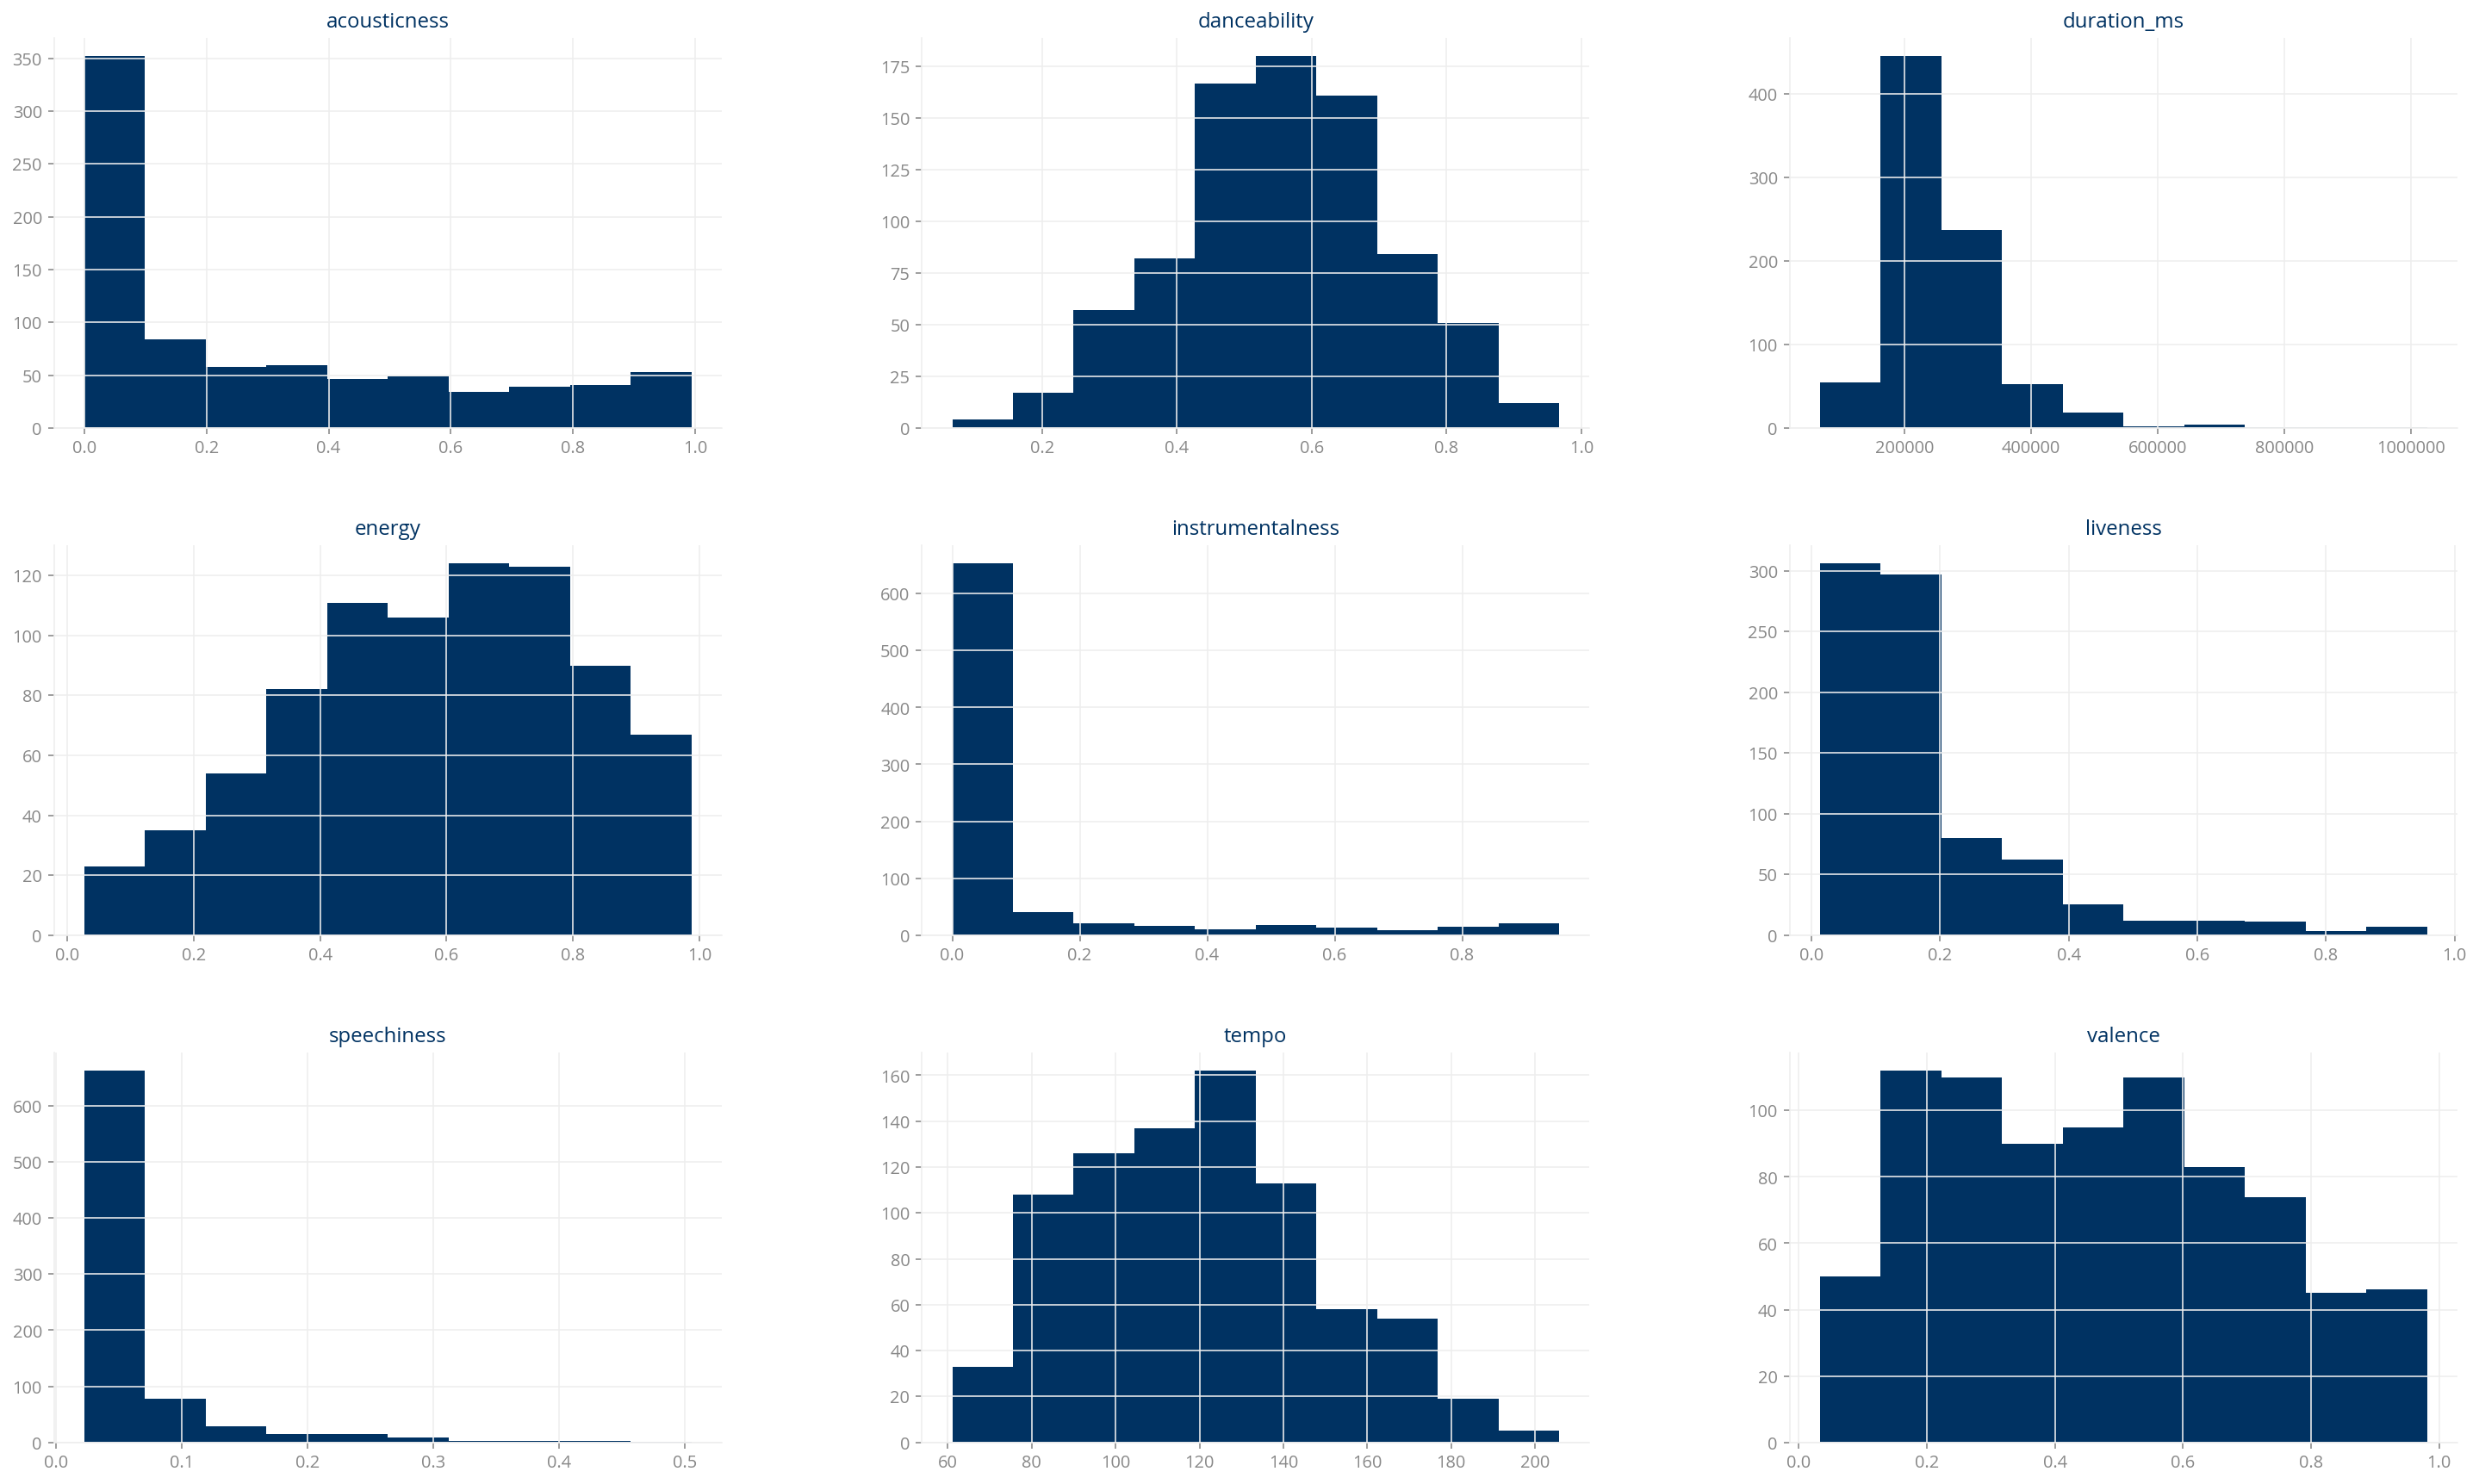

In [92]:
themes.theme_ucberkeley()
tracks_w_features[['acousticness', 'danceability', 'instrumentalness', 
           'energy', 'speechiness','tempo','valence','duration_ms',
           'liveness']].hist(figsize=(25,15))
plt.show()

### Danceability

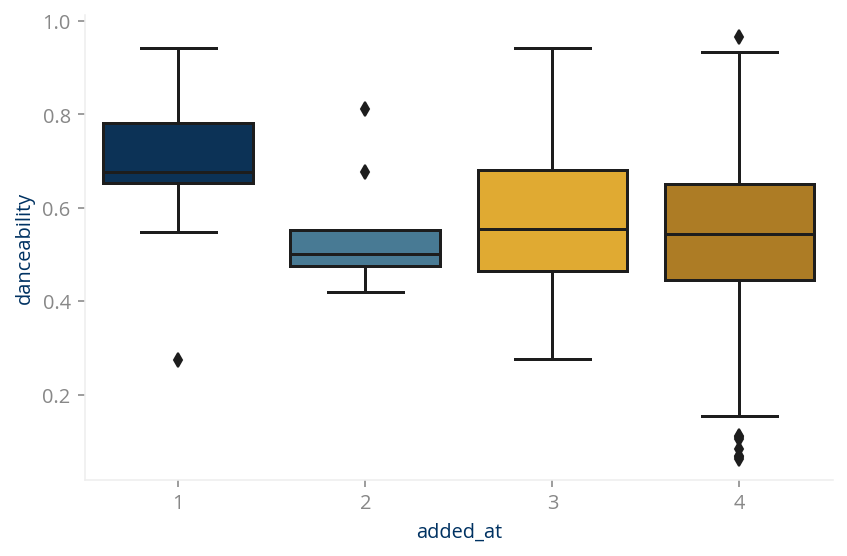

In [78]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.danceability)

plt.tight_layout()

### Energy

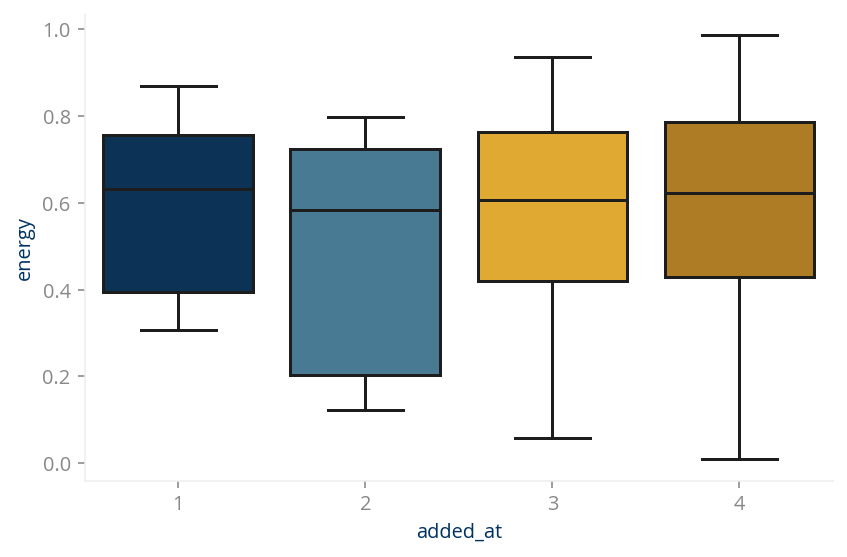

In [77]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.energy)

plt.tight_layout()

### Loudness

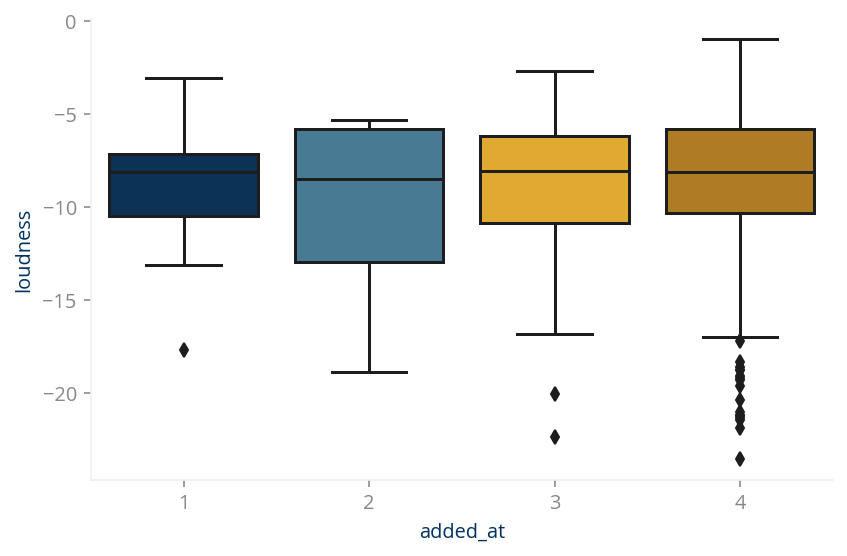

In [93]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.loudness)

plt.tight_layout()

### Acousticness

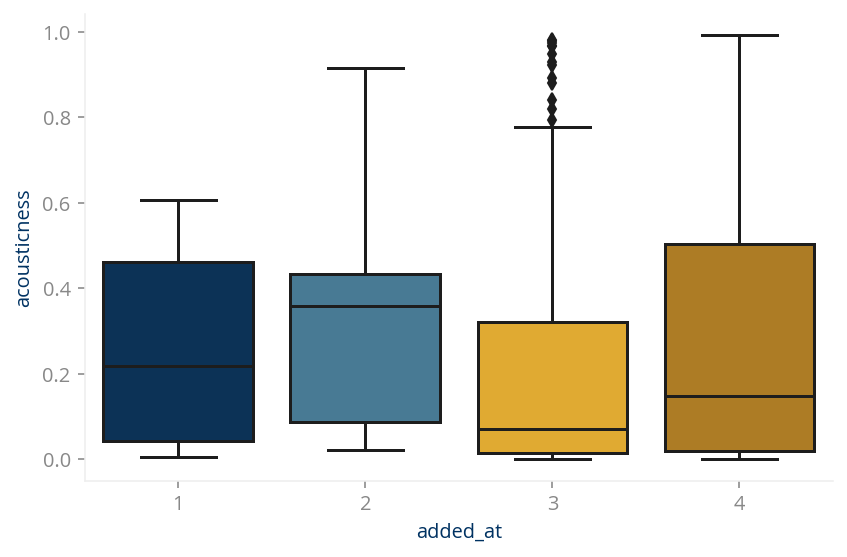

In [94]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.acousticness)

plt.tight_layout()

### Instrumentalness

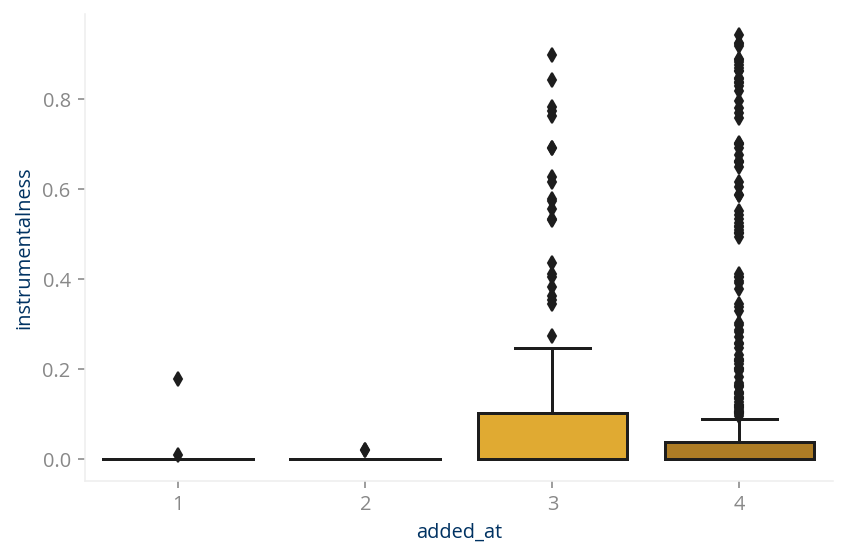

In [95]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.instrumentalness)

plt.tight_layout()

### Liveness

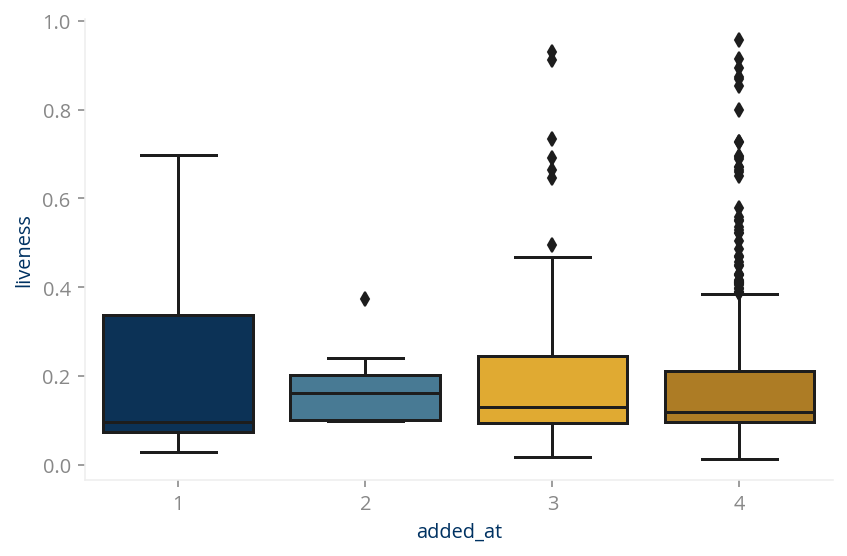

In [73]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.liveness)

plt.tight_layout()

### Speechiness

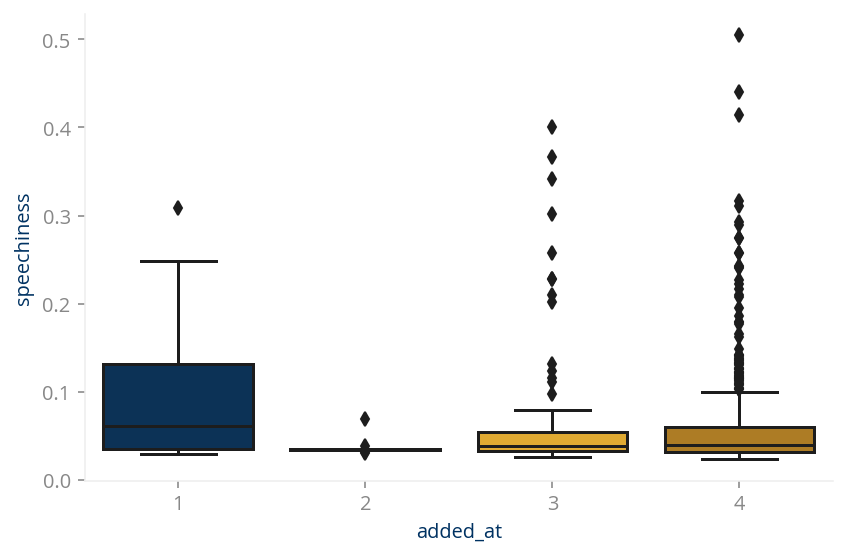

In [72]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.speechiness)

plt.tight_layout()

### Tempo

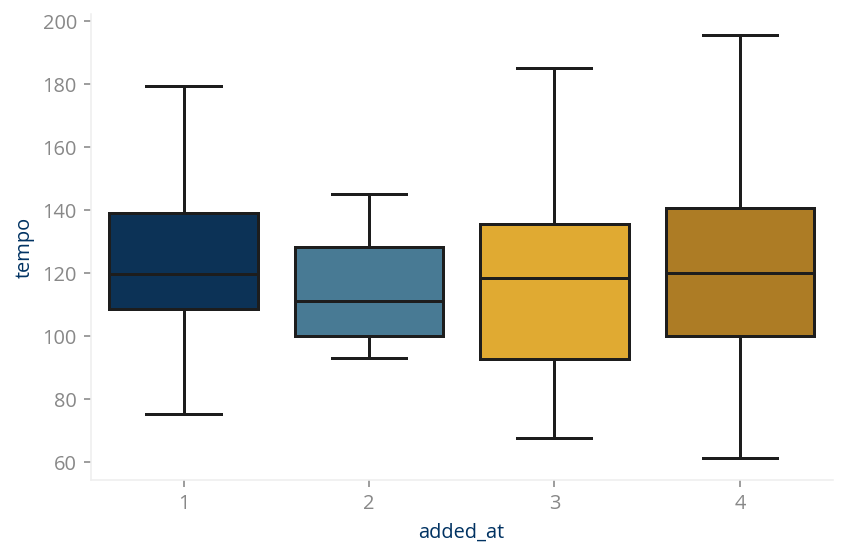

In [96]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.tempo)

plt.tight_layout()

### Valence

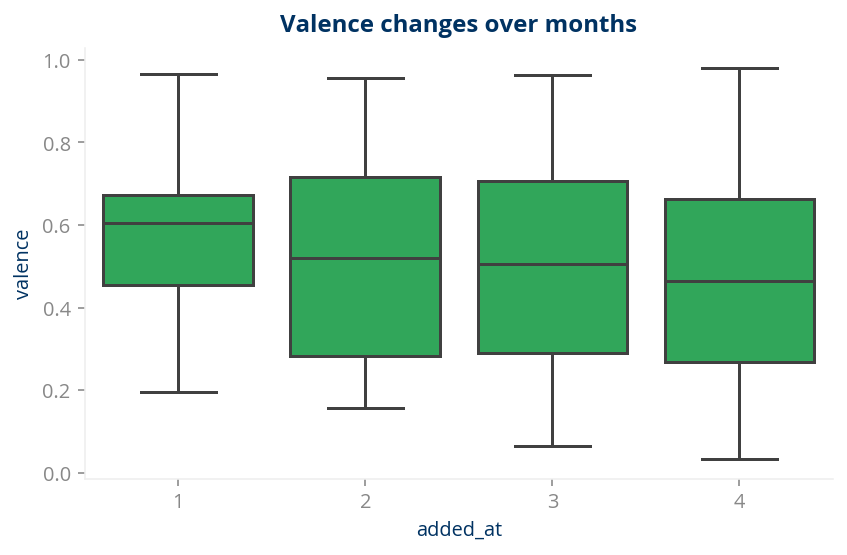

In [97]:
plt.figure(figsize=(6,4))

sns.boxplot(x=df_2020.added_at.dt.month, y=df_2020.valence, color='#1eb954')

plt.title("Valence changes over months", fontsize=12,y=1.01,weight='bold')

plt.tight_layout()

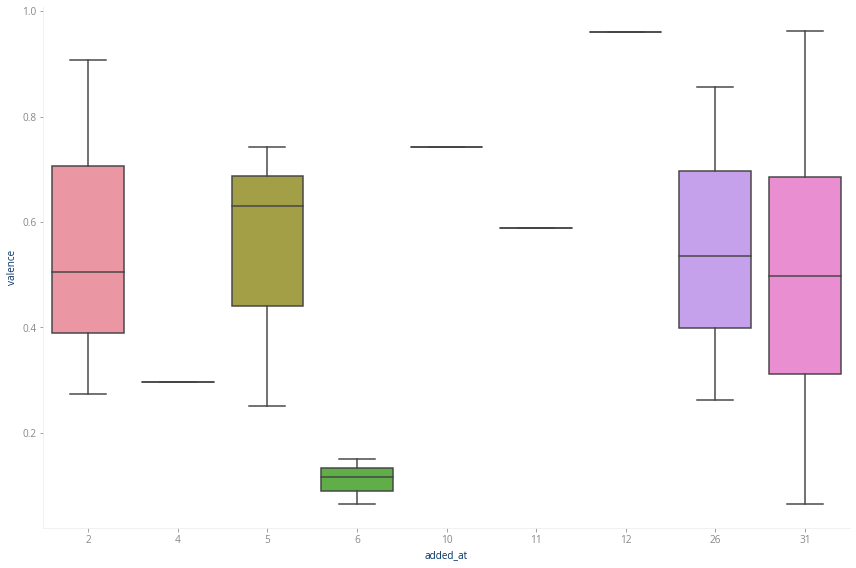

In [58]:
sns.boxplot(x=df_2020_Mar.added_at.dt.day, y=df_2020_Mar.valence)

plt.tight_layout()

### Seasonality x valence

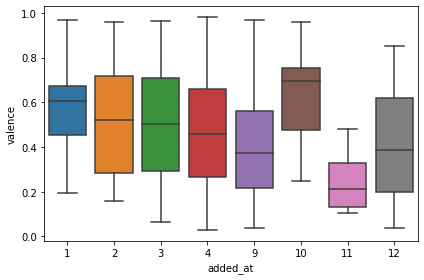

In [196]:
sns.boxplot(x=tracks_w_features.added_at.dt.month, y=tracks_w_features.valence)
plt.tight_layout()

### Seasonality x danceability

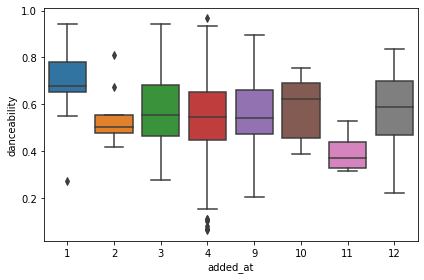

In [197]:
sns.boxplot(x=tracks_w_features.added_at.dt.month, y=tracks_w_features.danceability)
plt.tight_layout()

### Danceability x valence

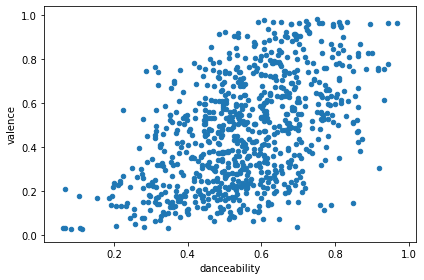

In [198]:
tracks_w_features.plot(kind='scatter', x='danceability', y='valence')
plt.tight_layout()

### Danceability x loudness

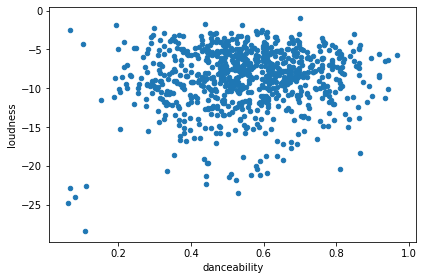

In [199]:
tracks_w_features.plot(kind='scatter', x='danceability', y='loudness')
plt.tight_layout()

### Danceability x tempo

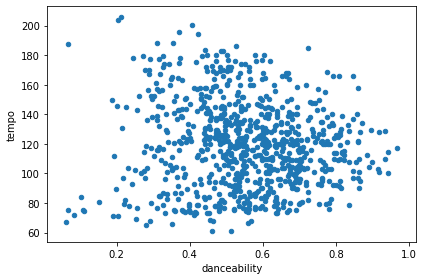

In [200]:
tracks_w_features.plot(kind='scatter', x='danceability', y='tempo')
plt.tight_layout()

### Instrumentalness x speechiness

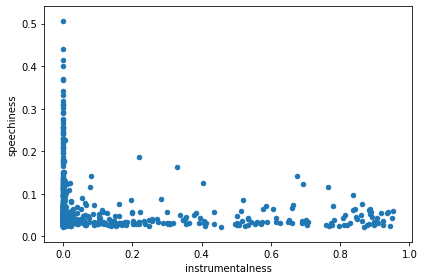

In [201]:
tracks_w_features.plot(kind='scatter', x='instrumentalness', y='speechiness')
plt.tight_layout()

## Vector distance

In [98]:
encode_fields = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
]

def encode(row):
    return np.array([
        (row[k] - tracks_w_features[k].min())
        / (tracks_w_features[k].max() - tracks_w_features[k].min())
        for k in encode_fields])

tracks_w_features_encoded = tracks_w_features.assign(
    encoded=tracks_w_features.apply(encode, axis=1))

In [99]:
tracks_w_features_encoded.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,added_at,song_title,artists,encoded
0,0.448,0.783,4,-6.507,1,0.0290,0.1150,0.000467,0.2080,0.756,...,43yoPh5r95O0sltSQoY6Iw,spotify:track:43yoPh5r95O0sltSQoY6Iw,https://api.spotify.com/v1/tracks/43yoPh5r95O0...,https://api.spotify.com/v1/audio-analysis/43yo...,413493,4,2019-09-21 18:38:24+00:00,Stuck Inside of Mobile with the Memphis Blues ...,Cat Power,"[0.4235895157707686, 0.7874114214255941, 0.363..."
1,0.520,0.411,0,-12.536,0,0.0250,0.2020,0.153000,0.3510,0.280,...,5a4MgIUSf9K8wXLSm6xPEx,spotify:track:5a4MgIUSf9K8wXLSm6xPEx,https://api.spotify.com/v1/tracks/5a4MgIUSf9K8...,https://api.spotify.com/v1/audio-analysis/5a4M...,510965,4,2019-09-21 18:38:25+00:00,High Hopes,Pink Floyd,"[0.503553976010662, 0.39974989578991243, 0.0, ..."
2,0.524,0.634,2,-8.968,1,0.0249,0.0166,0.000068,0.0895,0.634,...,7u8yddev0YnNFGkZoP8X2t,spotify:track:7u8yddev0YnNFGkZoP8X2t,https://api.spotify.com/v1/tracks/7u8yddev0YnN...,https://api.spotify.com/v1/audio-analysis/7u8y...,244600,4,2019-09-21 18:38:26+00:00,To the End - 2012 Remaster,Blur,"[0.5079964460239894, 0.6321383909962485, 0.181..."
3,0.668,0.695,0,-4.961,1,0.0283,0.4050,0.000000,0.4270,0.809,...,5g19EQEmBkiFuyTztsFjMU,spotify:track:5g19EQEmBkiFuyTztsFjMU,https://api.spotify.com/v1/tracks/5g19EQEmBkiF...,https://api.spotify.com/v1/audio-analysis/5g19...,267120,4,2019-09-21 18:38:26+00:00,Indian Summer,Stereophonics,"[0.6679253665037762, 0.6957065443934972, 0.0, ..."
4,0.211,0.692,7,-8.603,1,0.0416,0.0210,0.352000,0.6090,0.225,...,7jY2puQFxonAToK9HSnIuo,spotify:track:7jY2puQFxonAToK9HSnIuo,https://api.spotify.com/v1/tracks/7jY2puQFxonA...,https://api.spotify.com/v1/audio-analysis/7jY2...,332753,4,2019-09-21 18:38:26+00:00,He's Gone,The London Suede,"[0.1603731674811195, 0.6925802417674031, 0.636..."


In [100]:
tracks_w_features_encoded_product = tracks_w_features_encoded \
    .assign(temp=0) \
    .merge(tracks_w_features_encoded.assign(temp=0), on='temp', how='left') \
    .drop(columns='temp')

tracks_w_features_encoded_product = tracks_w_features_encoded_product[
    tracks_w_features_encoded_product.id_x != tracks_w_features_encoded_product.id_y
]

tracks_w_features_encoded_product['merge_id'] = tracks_w_features_encoded_product \
    .apply(lambda row: ''.join(sorted([row['id_x'], row['id_y']])), axis=1)

tracks_w_features_encoded_product['distance'] = tracks_w_features_encoded_product \
    .apply(lambda row: np.linalg.norm(row['encoded_x'] - row['encoded_y']), axis=1)

### The most similar songs

In [101]:
tracks_w_features_encoded_product \
    .sort_values('distance') \
    .drop_duplicates('merge_id') \
    [['artists_x', 'song_title_x', 'artists_y', 'song_title_y', 'distance']] \
    .head(10)

,artists_x,song_title_x,artists_y,song_title_y,distance
498118,Florence + The Machine,The End Of Love,Glass Animals,Gooey,0.011732
515325,OK Go,Here It Goes Again,The Jesus and Mary Chain,Some Candy Talking,0.108457
538153,Muse,Starlight,AC/DC,Thunderstruck,0.141387
454119,Ween,Mutilated Lips,Pulp,Something Changed,0.158513
600820,Men I Trust,Tailwhip,Blur,My Terracotta Heart,0.161328
160468,Talking Heads,Road to Nowhere,HAIM,The Steps,0.162264
274555,Halestorm,Bad Romance,Dodgy,Good Enough,0.162886
554713,Oasis,Wonderwall - Remastered,The Vaccines,If You Wanna,0.163632
127117,Glass Animals,Black Mambo,Christine and the Queens,"People, I've been sad",0.165064
240230,DYGL,Let It Out,Razorlight,In The Morning,0.165887


### The most different songs

In [108]:
tracks_w_features_encoded_product \
    .sort_values('distance', ascending=False) \
    .drop_duplicates('merge_id') \
    [['artists_x', 'song_title_x', 'artists_y', 'song_title_y', 'distance']] \
    .head(10)

,artists_x,song_title_x,artists_y,song_title_y,distance
98632,Per-Olov Kindgren,After Silence,"Skrillex,The Doors,Ray Manzarek,Robby Krieger",Breakn' a Sweat,2.274877
538780,Muse,Psycho,Piano Dreamers,Heaven's Gate,2.262105
582790,Dodgy,Good Enough,Piano Dreamers,Heaven's Gate,2.247200
249455,Iggy Pop,The Passenger,Piano Dreamers,Heaven's Gate,2.240898
99297,Per-Olov Kindgren,After Silence,Oasis,Slide Away,2.240454
53473,Piano Dreamers,Heaven's Gate,Marilyn Manson,Third Day of a Seven Day Binge,2.240242
178701,The Cure,Close to Me - Remastered,Lera Lynn,My Least Favorite Life - From The HBO Series T...,2.232612
217285,"Eminem,Juice WRLD",Godzilla (feat. Juice WRLD),Bill Evans,A Time For Love,2.231066
98482,Per-Olov Kindgren,I Miss You,Oasis,Slide Away,2.228107
285315,Elastica,Hold Me Now,Piano Dreamers,Heaven's Gate,2.228029


### The most average songs

In [103]:
tracks_w_features_encoded_product \
    .groupby(['artists_x', 'song_title_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance') \
    .head(10)

,artists_x,song_title_x,distance
660,The Animals,We Gotta Get Out Of This Place - UK Single Ver...,758.802868
661,The Band Perry,If I Die Young,761.310917
33,Arctic Monkeys,Do I Wanna Know?,767.353926
466,One Direction,Story of My Life,773.588932
778,Urge Overkill,"Girl, You'll Be a Woman Soon",775.938550
802,alt-J,Tessellate,783.974366
257,Guns N' Roses,Knockin' On Heaven's Door,786.414124
798,alt-J,Breezeblocks,787.258564
169,Divinyls,I Touch Myself,787.683498
649,"Tears For Fears,Dave Bascombe","Head Over Heels - Dave Bascombe 7"" N.Mix",789.882583


### The most outstanding songs

In [107]:
tracks_w_features_encoded_product \
    .groupby(['artists_x', 'song_title_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance', ascending=False) \
    .head(20)

,artists_x,song_title_x,distance
485,Piano Dreamers,Heaven's Gate,1443.515497
474,Per-Olov Kindgren,After Silence,1344.912261
475,Per-Olov Kindgren,I Miss You,1296.594968
65,Bill Evans,A Time For Love,1294.239954
372,MONO,Ashes in the Snow - Remastered,1277.382099
783,Wang Wen,Daybreak,1248.961555
627,Sufjan Stevens,Fourth of July,1248.171770
287,Immortal Technique,Dance with the Devil,1234.134745
211,Flanger,Bosco's Disposable Driver,1229.194120
354,Lera Lynn,My Least Favorite Life - From The HBO Series T...,1224.326841


### The most average artists

In [105]:
tracks_w_features_encoded_product \
    .groupby(['artists_x']) \
    .mean()['distance'] \
    .reset_index() \
    .sort_values('distance') \
    .head(10)

,artists_x,distance
309,The Band Perry,0.935271
228,One Direction,0.950355
364,Urge Overkill,0.953241
75,Divinyls,0.967670
304,"Tears For Fears,Dave Bascombe",0.970372
250,"Queen,David Bowie",0.971546
325,The Good Life,0.972714
251,Quinn Lewis,0.977826
236,"Peter Malick,Norah Jones",0.978545
276,"Skrillex,Ellie Goulding",0.979902


### The most outstanding artists

In [106]:
tracks_w_features_encoded_product \
    .groupby(['artists_x']) \
    .mean()['distance'] \
    .reset_index() \
    .sort_values('distance', ascending=False) \
    .head(10)

,artists_x,distance
241,Piano Dreamers,1.773361
234,Per-Olov Kindgren,1.622547
28,Bill Evans,1.589975
185,MONO,1.569265
368,Wang Wen,1.534351
129,Immortal Technique,1.516136
280,Snarky Puppy,1.492242
112,"Gorillaz,Mavis Staples,Pusha T",1.473258
195,Mark Sandman,1.472312
354,Thom Yorke,1.471484
